In [129]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
%matplotlib inline

In [44]:
torch.cuda.is_available()

True

In [3]:
tok = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', use_fast=False)
#model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')


In [4]:
#inputs = tok(['hälsa hälsan hälsans'], return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
#inputs = tok(X[:10].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [5]:
#outputs = model(**inputs)
#outputs = outputs['pooler_output'].detach().numpy().reshape(X.shape[0], -1)

In [45]:
class NLPTransformer(TransformerMixin):
    def __init__(self):
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = 10
        
    def fit(self, X, y=None):
        print('Fit called')
        
        
        return self
    
    def partial_fit(self, X, y=None):
        print('Partial Fit called')

        return self
        
    def transform(self, X):
        print('Transform Called')
       
        # Transform input tokens. This is most efficient if done in one batch 
        inputs = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

        # Run Bert model, We must mini batch this in order to not overflow the memory of the system
        transformed = []
        
        batches = int(np.ceil(X.shape[0] / self.batch_size))
        for batchId in range(batches):
            print(f'Running batch {batchId+1}/{batches}')
        
            inputs_batch = {}
            for key in inputs.keys():
                inputs_batch[key] = inputs[key][batchId * self.batch_size:(batchId + 1) * self.batch_size]

            outputs = self.Bert(**inputs_batch)
            outputs = outputs['pooler_output'].detach().numpy()
            print(f'output shape: {outputs.shape}')
            transformed.extend(outputs)
        
        transformed = np.array(transformed)
        print(f'transformed.shape: {transformed.shape}')
        
        return transformed

In [46]:
pipeline = Pipeline([    
            ('nlpTransformer', NLPTransformer()),
            ('clf', RandomForestClassifier())])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#Read the data

In [9]:
df = pd.read_csv('../data/bbc-text.csv')

In [10]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [11]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [12]:
df2 = pd.get_dummies(df, columns=['category'])

In [13]:
X = df2['text']

In [14]:
Y = df2.drop(columns=['text'])

In [241]:
#Test data anonymized
#df = pd.read_csv('../data/CRMIncidents_Anonymized.csv')
df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')

<ipython-input-241-01876a210620>:3: DtypeWarning: Columns (1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,41,43,45,47,49,51,52,54,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')


In [48]:
df.head()

,Unnamed: 0.1,Unnamed: 0,CRMIncidentId,IncidentId,LineId,Linje,JourneyId,TurNummer,Trafikslag,Ankomstdag,...,Enhet,Queue_SK,Kö,ModifiedOn,ContactId,Contact_SK,iBID,IsActive,TicketId,Beskrivning_Anonymized
0,0,0,673326.0,77DE23B5-43D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-10-29 11:33:19,586769.0,C0BDFF48-2C0B-E811-80F1-005056B64D75,NaN,True,NaN,"Hej,\r\r\n \r\r\nHar nu fått tag i föraren som..."
1,1,1,673354.0,EBD68435-41D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 08:17:09,331145.0,E429FD9A-5DEC-E411-80D6-0050569071BE,NaN,True,NaN,Buss 000 00:00\r\r\n\r\r\nKristianstad Hästtor...
2,2,2,673617.0,3ED0AA37-16D9-E811-80F4-005056B62B18,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2021-10-07 08:49:10,726145.0,12F4B35F-16D9-E811-80F4-005056B62B18,NaN,True,NaN,Skadeanmälan för påkörning av bil bakifrån vid...
3,3,3,673807.0,AAA91AC9-E0D8-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 10:36:12,603794.0,56A30A33-A32D-E811-80F2-005056B62B18,NaN,True,NaN,"Hej, \r\r\nVarför heter en av hållplatserna i ..."
4,4,4,673850.0,5F1165E6-63D9-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2019-11-27 15:06:13,22229.0,383EAEB1-1DEB-E411-80D8-005056903A38,NaN,True,NaN,Hej!\r\r\nHar en fråga som gäller busskurerna ...


In [49]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CRMIncidentId', 'IncidentId', 'LineId',
       'Linje', 'JourneyId', 'TurNummer', 'Trafikslag', 'Ankomstdag',
       'Händelsedatum', 'Hanteratdatum', 'Ärendenummer', 'KategoriId11',
       'Kategori11', 'KategoriId12', 'Kategori12', 'KategoriId13',
       'Kategori13', 'KategoriId21', 'Kategori21', 'KategoriId22',
       'Kategori22', 'KategoriId23', 'Kategori23', 'KategoriId31',
       'Kategori31', 'KategoriId32', 'Kategori32', 'KategoriId33',
       'Kategori33', 'KategoriId41', 'Kategori41', 'KategoriId42',
       'Kategori42', 'KategoriId43', 'Kategori43', 'Titel', 'CaseType_SK',
       'Ärendetyp', 'CaseOrigin_SK', 'Ursprung', 'Priority_SK', 'Prioritet',
       'IncidentStage_SK', 'ÄrendeStatus', 'Owner_SK', 'Handläggare',
       'BusinessUnit_SK', 'Enhet', 'Queue_SK', 'Kö', 'ModifiedOn', 'ContactId',
       'Contact_SK', 'iBID', 'IsActive', 'TicketId', 'Beskrivning_Anonymized'],
      dtype='object')

(array([5.210e+02, 5.880e+02, 0.000e+00, 1.200e+01, 0.000e+00, 2.960e+02,
        8.573e+03, 0.000e+00, 5.000e+00, 5.000e+00]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

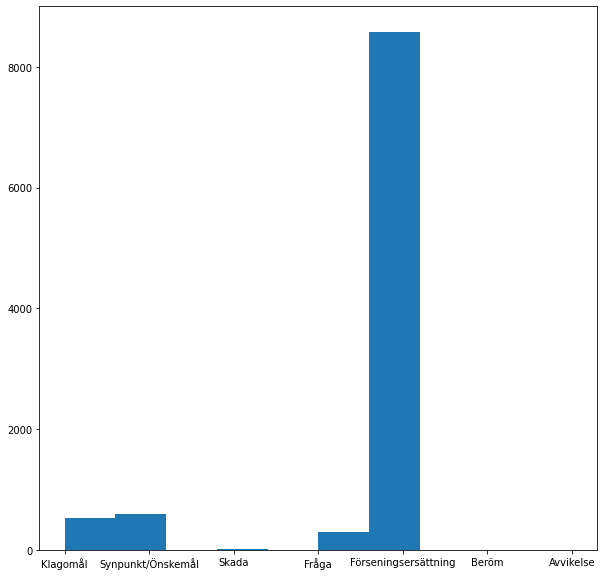

In [51]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [242]:
#Make a balanced training set
df[['Ärendetyp','Prioritet']].groupby(['Ärendetyp']).count()

,Prioritet
Ärendetyp,
Avvikelse,1325
Beröm,6057
Fråga,158037
Förseningsersättning,774416
Klagomål,281728
Skada,5194
Synpunkt/Önskemål,84306


In [243]:
df.shape

(1499845, 59)

In [244]:
categories = df['Ärendetyp'].unique()

In [245]:
categories

array(['Klagomål', 'Synpunkt/Önskemål', 'Skada', 'Fråga',
       'Förseningsersättning', 'Beröm', 'Avvikelse', nan], dtype=object)

In [235]:
df = df[:10000] #Max for this computer
df = df[~df['Ärendetyp'].isna()]
df = df[~df['Beskrivning_Anonymized'].isna()]
df.shape

2      Skada
6      Skada
21     Skada
43     Skada
70     Skada
222    Skada
239    Skada
240    Skada
282    Skada
331    Skada
Name: Ärendetyp, dtype: object

In [52]:
X = df['Beskrivning_Anonymized'].str.lower() #Lower case to slim the vocabulary

In [132]:
Y = pd.get_dummies(df['Ärendetyp'], columns=['Ärendetyp'])

In [133]:
classes = Y.columns

In [134]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [135]:
Y.shape

(10000, 7)

In [136]:
#Note in case of pytorch CrossEntropyLoss, the targets should be the class index, not one hot encoded
Y = Y.values.argmax(axis=1)


In [137]:
Y

array([4, 6, 5, ..., 3, 3, 3], dtype=int64)

In [57]:
Y.max()

6

In [62]:
#This could also be a target
Y2 = pd.get_dummies(df['Prioritet'], columns=['Prioritet'])

In [63]:
Y2.head()

,Hög,Normal
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


In [21]:
X.head()

0    hej,\r\n \r\nhar nu fått tag i föraren som är ...
1    buss 000 00:00\r\n\r\nkristianstad hästtorget ...
2    skadeanmälan för påkörning av bil bakifrån vid...
3    hej, \r\nvarför heter en av hållplatserna i lu...
4    hej!\r\nhar en fråga som gäller busskurerna i ...
Name: Beskrivning_Anonymized, dtype: object

In [22]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [23]:
Y.head()

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In [24]:
inputs = tok('hej, Har nu fått tag i föraren som är', return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [25]:
inputs

{'input_ids': tensor([[    2,  8819,    19,  1177,   346,   902,  1326,    31, 15367,    67,
            54,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
#Test train split

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [59]:
X_train.shape

(8000,)

In [146]:
Y_train[:5]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
1186887,0,0,0,1,0,0,0
136802,0,0,0,1,0,0,0
1380656,0,0,0,0,0,1,0
1125757,0,0,0,1,0,0,0
381602,0,0,0,1,0,0,0


In [60]:
class MiniBatcher():
    def __init__(self, X, Y, batch_size=100, max_epochs=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.batchId = 0
        self.epochId = 0
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1
            print(self.batchId, self.epochId)
            print(len(X_mini))
            if len(X_mini) < self.batch_size:
                self.epochId += 1
                self.batchId = 0
                if self.epochId <= self.max_epochs:
                    print('will break')
                    break
            
            yield X_mini, Y_mini
            


In [30]:
mMiniBatcher = MiniBatcher(X_train, Y_train)

In [31]:
batchIterator = mMiniBatcher.getBatchIterator()

In [16]:
#Train the model
#output = pipeline.fit(X_train[:25], Y_train[:25].values)
#output = pipeline.fit(X_train[:1500], Y_train[:1500].values)
output = pipeline.fit(X_train, Y_train.values)

Fit called
Transform Called
Running batch 1/800
output shape: (10, 768)
Running batch 2/800
output shape: (10, 768)
Running batch 3/800
output shape: (10, 768)
Running batch 4/800
output shape: (10, 768)
Running batch 5/800
output shape: (10, 768)
Running batch 6/800
output shape: (10, 768)
Running batch 7/800
output shape: (10, 768)
Running batch 8/800
output shape: (10, 768)
Running batch 9/800
output shape: (10, 768)
Running batch 10/800
output shape: (10, 768)
Running batch 11/800
output shape: (10, 768)
Running batch 12/800
output shape: (10, 768)
Running batch 13/800
output shape: (10, 768)
Running batch 14/800
output shape: (10, 768)
Running batch 15/800
output shape: (10, 768)
Running batch 16/800
output shape: (10, 768)
Running batch 17/800
output shape: (10, 768)
Running batch 18/800
output shape: (10, 768)
Running batch 19/800
output shape: (10, 768)
Running batch 20/800
output shape: (10, 768)
Running batch 21/800
output shape: (10, 768)
Running batch 22/800
output shape: (

output shape: (10, 768)
Running batch 182/800
output shape: (10, 768)
Running batch 183/800
output shape: (10, 768)
Running batch 184/800
output shape: (10, 768)
Running batch 185/800
output shape: (10, 768)
Running batch 186/800
output shape: (10, 768)
Running batch 187/800
output shape: (10, 768)
Running batch 188/800
output shape: (10, 768)
Running batch 189/800
output shape: (10, 768)
Running batch 190/800
output shape: (10, 768)
Running batch 191/800
output shape: (10, 768)
Running batch 192/800
output shape: (10, 768)
Running batch 193/800
output shape: (10, 768)
Running batch 194/800
output shape: (10, 768)
Running batch 195/800
output shape: (10, 768)
Running batch 196/800
output shape: (10, 768)
Running batch 197/800
output shape: (10, 768)
Running batch 198/800
output shape: (10, 768)
Running batch 199/800
output shape: (10, 768)
Running batch 200/800
output shape: (10, 768)
Running batch 201/800
output shape: (10, 768)
Running batch 202/800
output shape: (10, 768)
Running ba

output shape: (10, 768)
Running batch 361/800
output shape: (10, 768)
Running batch 362/800
output shape: (10, 768)
Running batch 363/800
output shape: (10, 768)
Running batch 364/800
output shape: (10, 768)
Running batch 365/800
output shape: (10, 768)
Running batch 366/800
output shape: (10, 768)
Running batch 367/800
output shape: (10, 768)
Running batch 368/800
output shape: (10, 768)
Running batch 369/800
output shape: (10, 768)
Running batch 370/800
output shape: (10, 768)
Running batch 371/800
output shape: (10, 768)
Running batch 372/800
output shape: (10, 768)
Running batch 373/800
output shape: (10, 768)
Running batch 374/800
output shape: (10, 768)
Running batch 375/800
output shape: (10, 768)
Running batch 376/800
output shape: (10, 768)
Running batch 377/800
output shape: (10, 768)
Running batch 378/800
output shape: (10, 768)
Running batch 379/800
output shape: (10, 768)
Running batch 380/800
output shape: (10, 768)
Running batch 381/800
output shape: (10, 768)
Running ba

output shape: (10, 768)
Running batch 540/800
output shape: (10, 768)
Running batch 541/800
output shape: (10, 768)
Running batch 542/800
output shape: (10, 768)
Running batch 543/800
output shape: (10, 768)
Running batch 544/800
output shape: (10, 768)
Running batch 545/800
output shape: (10, 768)
Running batch 546/800
output shape: (10, 768)
Running batch 547/800
output shape: (10, 768)
Running batch 548/800
output shape: (10, 768)
Running batch 549/800
output shape: (10, 768)
Running batch 550/800
output shape: (10, 768)
Running batch 551/800
output shape: (10, 768)
Running batch 552/800
output shape: (10, 768)
Running batch 553/800
output shape: (10, 768)
Running batch 554/800
output shape: (10, 768)
Running batch 555/800
output shape: (10, 768)
Running batch 556/800
output shape: (10, 768)
Running batch 557/800
output shape: (10, 768)
Running batch 558/800
output shape: (10, 768)
Running batch 559/800
output shape: (10, 768)
Running batch 560/800
output shape: (10, 768)
Running ba

output shape: (10, 768)
Running batch 719/800
output shape: (10, 768)
Running batch 720/800
output shape: (10, 768)
Running batch 721/800
output shape: (10, 768)
Running batch 722/800
output shape: (10, 768)
Running batch 723/800
output shape: (10, 768)
Running batch 724/800
output shape: (10, 768)
Running batch 725/800
output shape: (10, 768)
Running batch 726/800
output shape: (10, 768)
Running batch 727/800
output shape: (10, 768)
Running batch 728/800
output shape: (10, 768)
Running batch 729/800
output shape: (10, 768)
Running batch 730/800
output shape: (10, 768)
Running batch 731/800
output shape: (10, 768)
Running batch 732/800
output shape: (10, 768)
Running batch 733/800
output shape: (10, 768)
Running batch 734/800
output shape: (10, 768)
Running batch 735/800
output shape: (10, 768)
Running batch 736/800
output shape: (10, 768)
Running batch 737/800
output shape: (10, 768)
Running batch 738/800
output shape: (10, 768)
Running batch 739/800
output shape: (10, 768)
Running ba

In [17]:
output.predict(X_test[:10])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


array([[0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [135]:
probs = output.predict_proba(X_test[:15])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (5, 768)
transformed.shape: (15, 768)


In [53]:
Y_test[:3].values

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [75]:
Y_test[:15]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
521,0,0,1,0,0,0,0
941,0,0,0,0,0,0,1
741,0,0,1,0,0,0,0
980,0,0,0,0,0,0,1
411,0,0,0,0,0,0,1
679,0,0,1,0,0,0,0
673,0,0,0,0,0,0,1
513,0,0,0,0,1,0,0
773,0,0,0,0,1,0,0
136,0,0,0,0,0,0,1


In [24]:
#This will predict the classes for each row. The class with the highest probability is selected
def PredictClasses(model, X):
    probs = model.predict_proba(X)
    probs = np.array(probs) #List to (N, num_classes, 2)
    predictedClasses = np.argmax(probs[:,:,1].T, axis=1) #First index classifies it as 0, second as 1, Then get the max index for each row
    
    return predictedClasses
    
    
    

In [105]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [31]:
result = PredictClasses(pipeline, X_test[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


In [29]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2], dtype=int64)

In [32]:
Y_test[10:20]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
2750,0,0,0,1,0,0,0
7487,0,0,0,1,0,0,0
5272,0,0,0,1,0,0,0
5653,0,0,0,1,0,0,0
3999,0,0,0,1,0,0,0
6033,0,0,0,1,0,0,0
582,0,0,0,0,1,0,0
9930,0,0,0,1,0,0,0
7051,0,0,0,1,0,0,0
8158,0,0,0,1,0,0,0


In [38]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 3], dtype=int64)

In [41]:
ost = Y_test[10:20].to_numpy().argmax(axis=1)
ost

array([3, 3, 3, 3, 3, 3, 4, 3, 3, 3], dtype=int64)

In [51]:
result.shape

(10,)

In [77]:
cm = confusion_matrix(ost, result,normalize='true')
cm

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

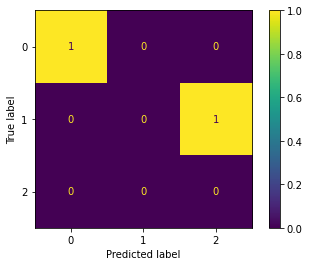

In [78]:
ConfusionMatrixDisplay(confusion_matrix=cm,).plot()

TypeError: float() argument must be a string or a number, not 'ConfusionMatrixDisplay'

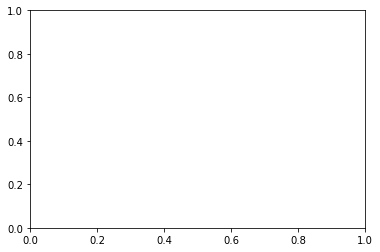

In [70]:
plt.(ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(ost, result)))


In [61]:
confusion_matrix(ost, result)

array([[9, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=int64)

In [62]:
#results = PredictClasses(pipeline, X_test[:15])
results = PredictClasses(pipeline, X_test)
results

Transform Called
Running batch 1/200


KeyboardInterrupt: 

In [85]:
results

array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [89]:
targets = np.argmax(np.array(Y), axis=1)
targets

array([4, 6, 5, ..., 4, 4, 2], dtype=int64)

In [34]:
Y_test.columns

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [79]:
def EvaluateModelUsingProbs(model, X_test, Y_test):
    Y_pred = PredictClasses(model, X_test) #1D-array with classes
    targets = np.argmax(np.array(Y_test), axis=1) #1D-array with classes
    
    total_hits = np.sum(np.sum(Y_pred == targets))
    total_misses = np.sum(np.sum(Y_pred != targets))
    total_accuracy = total_hits/(total_hits + total_misses)
    print(f'Total Accuracy: {total_accuracy}')
    cm = confusion_matrix(targets, Y_pred, normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cm,).plot()
    

In [22]:
#Evaluate the model and print the accuracy

def EvaluateModel(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    
    total_hits = np.sum(np.sum(Y_pred == Y_test))
    total_misses = np.sum(np.sum(Y_pred != Y_test))
    total_accuracy = total_hits/(total_hits + total_misses)
       
    target_names = [name for name in Y.columns]

    precisions = []
    recalls = []
    f1scores = []
    for (name, col) in zip(target_names, range(len(target_names))):
        y_test = Y_test[name].values
        y_pred = Y_pred[:, col]
        
        if(np.max(y_test) <= 1):
            #Only one category
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1scores.append(f1_score(y_test, y_pred))
        print(f'Category: {name}')
        print(classification_report(y_test, y_pred))
        print('-'*42)
     
    
    print(f'Total Accuracy: {total_accuracy}')
    print(f'Average Precission: {np.average(precisions)}')
    print(f'Average Recall: {np.average(recalls)}')
    print(f'Average F1 Score: {np.average(f1scores)}')

In [88]:
EvaluateModel(pipeline, X_test[:100], Y_test[:100])

Transform Called
Running batch 1/10
output shape: (10, 768)
Running batch 2/10
output shape: (10, 768)
Running batch 3/10
output shape: (10, 768)
Running batch 4/10
output shape: (10, 768)
Running batch 5/10
output shape: (10, 768)
Running batch 6/10
output shape: (10, 768)
Running batch 7/10
output shape: (10, 768)
Running batch 8/10
output shape: (10, 768)
Running batch 9/10
output shape: (10, 768)
Running batch 10/10
output shape: (10, 768)
transformed.shape: (100, 768)
Category: Avvikelse
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------------------
Category: Beröm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    ac

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-

Transform Called
Running batch 1/60
output shape: (10, 768)
Running batch 2/60
output shape: (10, 768)
Running batch 3/60
output shape: (10, 768)
Running batch 4/60
output shape: (10, 768)
Running batch 5/60
output shape: (10, 768)
Running batch 6/60
output shape: (10, 768)
Running batch 7/60
output shape: (10, 768)
Running batch 8/60
output shape: (10, 768)
Running batch 9/60
output shape: (10, 768)
Running batch 10/60
output shape: (10, 768)
Running batch 11/60
output shape: (10, 768)
Running batch 12/60
output shape: (10, 768)
Running batch 13/60
output shape: (10, 768)
Running batch 14/60
output shape: (10, 768)
Running batch 15/60
output shape: (10, 768)
Running batch 16/60
output shape: (10, 768)
Running batch 17/60
output shape: (10, 768)
Running batch 18/60
output shape: (10, 768)
Running batch 19/60
output shape: (10, 768)
Running batch 20/60
output shape: (10, 768)
Running batch 21/60
output shape: (10, 768)
Running batch 22/60
output shape: (10, 768)
Running batch 23/60
outp

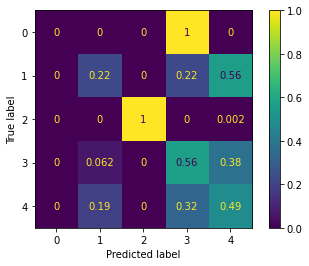

In [82]:
EvaluateModelUsingProbs(pipeline, X_test[:600], Y_test[:600])

In [108]:
EvaluateModelUsingProbs(pipeline, X_train, Y_train)

Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch 23/80
outp

In [130]:
y.iloc[0:10].values

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [140]:
#Save, Load model

In [2]:
from joblib import dump, load

In [15]:
modelName = 'BertModel.joblib'

In [142]:

dump(pipeline, modelName ) 

['BertModel.joblib']

In [18]:
loadedModel = load(modelName) 

In [19]:
loadedModel.predict(X_test[100:120])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (10, 768)
transformed.shape: (20, 768)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [1]:
#Deep learning using pytorch

In [159]:
from torch import nn, optim
import torch.nn.functional as F

class TorchNLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Linear(768, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),              
                          nn.Linear(64, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
            
    def forward(self, X):
        print('Forward Called')
       
        #Check device
        device = self.Bert.device
        
        # Transform input tokens. This is most efficient if done in one batch 
        X = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
        
        X = self.Bert(**X)
        X = X['pooler_output']
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = torchModel(X)
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            self.train()
            return top_class

In [160]:
torchModel.Bert.device

device(type='cpu')

In [97]:
Y.max()

6

In [161]:
#n_classes = Y.shape[1] #In case of one hot encoded, which we don't have anymore
n_classes = Y.max() + 1
torchModel = TorchNLP(n_classes = n_classes)

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
output = torchModel(X_train[:5])

Forward Called


In [68]:
output

tensor([[0.1394, 0.1599, 0.1548, 0.1324, 0.1248, 0.1408, 0.1479],
        [0.1428, 0.1565, 0.1440, 0.1306, 0.1277, 0.1471, 0.1513],
        [0.1410, 0.1569, 0.1521, 0.1396, 0.1235, 0.1379, 0.1489],
        [0.1318, 0.1499, 0.1585, 0.1312, 0.1373, 0.1510, 0.1404],
        [0.1423, 0.1517, 0.1463, 0.1242, 0.1348, 0.1532, 0.1476]],
       grad_fn=<SoftmaxBackward0>)

In [205]:
mMiniBatcherTrain = MiniBatcher(X_train[:100000], Y_train[:100000], batch_size=100)
mMiniBatcherTest = MiniBatcher(X_test[:1000], Y_test[:1000], batch_size=100)

In [70]:
for param in torchModel.parameters():
    print(type(param.data), param.size(), param.requires_grad)

<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [206]:
cuda_enabled = torch.cuda.is_available()
if cuda_enabled:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'We are running on device: {device}')

We are running on device: cuda


In [207]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModel.parameters(), lr=0.003)
optimizer = optim.Adam(torchModel.parameters(), lr=0.0015)

epochs = 15
steps = 0
train_losses, test_losses = [], []

torchModel.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        print('Training batch...')
        optimizer.zero_grad()
 
        print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        
        print('Running torch')
        output = torchModel(images)
        
        print(f'output.shape: {output.shape}')
        print('Calculating loss')
        
        loss = criterion(output, labels)
        print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss}')
        running_loss += batch_loss
        
   
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModel.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            output = torchModel(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')

    torchModel.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(mMiniBatcherTest.X)))

1 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.18662968277931213
2 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1950482875108719
3 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12659981846809387
4 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16553503274917603
5 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13867506384849548
6 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch l

Batch loss: 0.21011856198310852
49 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11812769621610641
50 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11132189631462097
51 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14092807471752167
52 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.2256338894367218
53 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.10291335731744766
54 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 7.9253],
        [ 9.5865],
        [ 1.2157],
        [ 9.5950],
        [ 8.1377],
        [ 2.3382],
        [ 9.9985],
        [ 1.1759],
        [ 9.9775],
        [ 0.8988],
        [ 9.0827],
        [ 9.1451],
        [ 8.2916],
        [ 9.8378],
        [ 6.8043],
        [10.0248],
        [ 6.6454],
        [ 8.1018],
        [ 9.5056],
        [ 9.8743],
        [10.9104],
        [ 8.6084],
        [10.3429],
        [ 1.3154],
        [ 8.7094],
        [10.0508],
        [10.8162],
        [ 7.2226],
        [10.2480],
        [ 9.7093],
        [ 0.7658],
        [ 1.8079],
        [ 0.9875],
        [ 6.8040],
        [ 9.3374],
        [ 9.5550],
        [ 1.2365],
        [ 9.3395],
        [ 8.2523],
        [ 8.2307],
        [ 9.8109],
        [10.2184],
        [ 0.6759],
        [ 9.2807],
        [ 1.7183],
        [ 9.6688],
        [ 6.7652],
        [ 9.2555],
        [ 8.2214],
        [ 8.1453],
        [10.0098],
        [ 1.2897],
        [ 8.

tensor([[ 6.7646],
        [ 9.4433],
        [ 9.4840],
        [10.3134],
        [ 9.3439],
        [ 8.9501],
        [ 7.1500],
        [ 7.7304],
        [ 1.3015],
        [ 7.5511],
        [ 6.5555],
        [ 1.5260],
        [ 8.5042],
        [ 1.5054],
        [ 9.0964],
        [ 9.0964],
        [ 8.6327],
        [ 7.5116],
        [10.2580],
        [ 8.8757],
        [ 9.8761],
        [ 8.5342],
        [ 7.4696],
        [ 0.8623],
        [ 9.0905],
        [ 7.4953],
        [ 8.9436],
        [ 9.1307],
        [ 8.4615],
        [10.1304],
        [ 8.3094],
        [ 8.8563],
        [ 1.2358],
        [ 7.2165],
        [ 8.4583],
        [ 7.5899],
        [ 1.1753],
        [ 9.6143],
        [ 9.7914],
        [ 8.7411],
        [ 7.7941],
        [ 0.7643],
        [ 0.9920],
        [ 8.7906],
        [ 9.5924],
        [ 8.1572],
        [ 6.9308],
        [ 8.5014],
        [ 7.5306],
        [ 8.5098],
        [ 9.1075],
        [ 1.2428],
        [ 7.

Batch loss: 0.1754724383354187
15 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.2129792422056198
16 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1494053602218628
17 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1712520569562912
18 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15509241819381714
19 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.2658078074455261
20 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
C

Batch loss: 0.1709701418876648
63 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12590907514095306
64 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1828901171684265
65 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.32751724123954773
66 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.22188454866409302
67 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1575213223695755
68 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])

tensor([[10.0119],
        [ 2.2408],
        [ 9.8459],
        [11.0082],
        [ 2.0098],
        [ 9.3825],
        [ 9.8202],
        [ 8.2987],
        [ 1.2170],
        [ 8.9351],
        [ 9.3239],
        [10.2124],
        [ 9.5825],
        [ 8.0451],
        [ 1.4646],
        [ 8.2398],
        [ 9.8178],
        [ 7.9640],
        [10.3597],
        [ 9.1474],
        [ 9.2088],
        [10.6124],
        [ 8.4568],
        [10.7897],
        [ 9.1145],
        [ 9.4143],
        [10.0119],
        [11.4546],
        [10.2906],
        [ 9.9322],
        [ 9.4478],
        [10.2858],
        [ 7.8750],
        [ 9.7483],
        [11.5202],
        [ 9.4454],
        [ 8.9267],
        [ 9.4773],
        [10.0202],
        [ 9.9877],
        [ 7.9752],
        [10.5450],
        [10.8664],
        [10.7684],
        [10.9121],
        [ 9.2963],
        [ 9.4520],
        [11.2233],
        [ 9.3043],
        [ 8.8317],
        [11.4393],
        [ 7.7679],
        [ 1.

tensor([[ 9.4975],
        [10.6542],
        [ 9.5529],
        [ 9.6968],
        [10.1068],
        [ 8.1489],
        [ 9.5248],
        [ 8.7041],
        [ 8.1633],
        [ 0.8241],
        [ 2.2708],
        [ 9.4992],
        [10.0411],
        [ 8.6998],
        [ 8.8501],
        [ 1.1926],
        [10.2890],
        [ 8.6804],
        [10.3253],
        [10.1641],
        [ 2.5627],
        [ 8.1780],
        [10.3406],
        [10.1084],
        [ 8.9748],
        [10.7473],
        [ 8.9823],
        [ 9.2377],
        [12.2732],
        [ 9.4475],
        [10.2908],
        [ 2.3981],
        [ 9.1970],
        [ 7.7527],
        [ 9.6253],
        [10.8083],
        [ 8.4715],
        [10.8941],
        [10.1318],
        [ 8.5880],
        [10.3134],
        [10.8296],
        [ 9.3857],
        [ 1.5208],
        [10.0387],
        [11.2564],
        [ 9.7952],
        [10.2079],
        [10.0524],
        [ 9.3226],
        [ 8.5313],
        [10.7684],
        [ 9.

Batch loss: 0.21529455482959747
26 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.2142384946346283
27 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.19260196387767792
28 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16749924421310425
29 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15850767493247986
30 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12242074310779572
31 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

Batch loss: 0.14872747659683228
74 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14639252424240112
75 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12224575132131577
76 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14143532514572144
77 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1978352665901184
78 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1355588585138321
79 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7]

tensor([[ 9.7928],
        [ 9.3511],
        [ 8.7482],
        [ 9.0577],
        [ 9.9212],
        [ 1.7017],
        [ 8.1299],
        [ 8.5603],
        [ 8.4062],
        [ 1.0036],
        [ 7.7763],
        [10.2504],
        [ 9.9991],
        [ 9.0322],
        [ 9.2203],
        [ 9.9835],
        [ 0.4798],
        [ 9.4303],
        [ 9.8499],
        [10.4224],
        [ 8.6334],
        [ 8.5584],
        [ 9.7602],
        [ 9.1469],
        [10.5625],
        [ 8.9891],
        [ 8.7779],
        [ 1.7649],
        [ 8.8606],
        [ 9.8525],
        [ 8.7348],
        [ 9.8563],
        [ 0.8771],
        [ 9.6106],
        [10.7924],
        [10.3483],
        [ 8.5757],
        [ 9.4388],
        [ 2.6575],
        [ 7.6719],
        [ 9.7868],
        [ 9.3152],
        [ 9.2455],
        [ 8.1006],
        [ 0.5752],
        [ 8.6969],
        [ 7.9568],
        [ 8.0957],
        [ 0.9458],
        [ 9.6263],
        [ 1.5737],
        [ 8.4082],
        [ 9.

tensor([[ 9.1865],
        [ 8.6185],
        [ 1.2145],
        [ 8.0893],
        [10.5242],
        [10.1350],
        [ 9.8554],
        [ 8.8479],
        [ 1.0128],
        [ 1.0677],
        [ 9.7400],
        [ 8.2236],
        [ 8.9769],
        [10.3344],
        [ 9.3911],
        [ 7.8608],
        [ 0.7767],
        [ 8.0611],
        [ 2.1548],
        [ 7.3168],
        [ 8.9144],
        [ 8.8527],
        [ 8.8046],
        [ 8.4572],
        [ 8.3908],
        [ 9.5631],
        [ 9.1198],
        [ 8.6913],
        [ 7.9206],
        [ 9.5256],
        [10.2205],
        [ 8.6051],
        [ 9.5095],
        [ 1.6143],
        [ 9.8545],
        [10.3701],
        [ 9.3262],
        [ 8.6821],
        [ 8.6894],
        [ 9.8447],
        [ 8.5847],
        [ 9.2800],
        [ 9.3442],
        [ 1.6746],
        [ 9.5073],
        [ 9.2073],
        [ 1.6636],
        [ 7.1074],
        [ 9.6100],
        [ 9.4943],
        [10.4262],
        [ 0.4968],
        [ 1.

Batch loss: 0.1619705706834793
38 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11702404171228409
39 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.18420198559761047
40 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12591002881526947
41 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11687944084405899
42 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.09222082048654556
43 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 0.9606],
        [ 9.3460],
        [10.6870],
        [10.4547],
        [ 8.7406],
        [ 8.9975],
        [10.5629],
        [11.3337],
        [ 9.4360],
        [10.6359],
        [ 9.5120],
        [ 8.6769],
        [10.5245],
        [ 2.9286],
        [10.5986],
        [10.1757],
        [10.2411],
        [ 1.1268],
        [11.3318],
        [10.3690],
        [ 6.0740],
        [10.4068],
        [11.2778],
        [ 7.8890],
        [ 9.5124],
        [10.6079],
        [11.6260],
        [10.0760],
        [10.6922],
        [ 1.2195],
        [ 8.8963],
        [10.7731],
        [ 1.4396],
        [ 8.2513],
        [10.8466],
        [ 7.7634],
        [ 2.6171],
        [ 9.3595],
        [10.5423],
        [10.9882],
        [ 2.6775],
        [11.9114],
        [ 9.1000],
        [ 3.1198],
        [11.8058],
        [10.4504],
        [ 8.3421],
        [ 0.8376],
        [ 1.4660],
        [10.5765],
        [ 8.7320],
        [ 8.3546],
        [10.

tensor([[ 1.2834],
        [ 9.6031],
        [11.4735],
        [10.9015],
        [ 8.8137],
        [ 1.8927],
        [10.1416],
        [10.1526],
        [11.0812],
        [10.5679],
        [10.0676],
        [10.5026],
        [ 1.2620],
        [10.5032],
        [ 1.5558],
        [ 9.2416],
        [ 9.9827],
        [ 9.3783],
        [ 9.3211],
        [ 0.8005],
        [10.0457],
        [ 0.7577],
        [11.4740],
        [11.7754],
        [ 1.1380],
        [ 9.5790],
        [ 8.9443],
        [10.5524],
        [ 9.7040],
        [ 1.8787],
        [ 9.2579],
        [10.7703],
        [ 9.3514],
        [10.6557],
        [ 9.9601],
        [ 9.9269],
        [ 9.5140],
        [ 9.4791],
        [ 8.7897],
        [ 8.8513],
        [ 1.5707],
        [ 8.5437],
        [11.3728],
        [10.0814],
        [ 0.8711],
        [ 4.0280],
        [10.9193],
        [ 9.4020],
        [ 9.8381],
        [10.5595],
        [ 0.9835],
        [ 9.7665],
        [10.

Batch loss: 0.1553197056055069
3 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1096489429473877
4 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1728377789258957
5 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11313268542289734
6 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13269047439098358
7 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16764546930789948
8 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calcu

Batch loss: 0.10164093971252441
51 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.10427743196487427
52 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.20872874557971954
53 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.09131255000829697
54 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12474852800369263
55 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.17941401898860931
56 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 

tensor([[ 8.4996],
        [10.3441],
        [ 1.5233],
        [ 9.8762],
        [ 9.5217],
        [ 2.7969],
        [10.8261],
        [ 1.2175],
        [10.7316],
        [ 0.8850],
        [ 9.3422],
        [ 9.9880],
        [ 9.3359],
        [10.3574],
        [ 8.2927],
        [10.9752],
        [ 7.5446],
        [ 8.5525],
        [ 9.7518],
        [ 9.9870],
        [11.3682],
        [ 9.2619],
        [10.3863],
        [ 1.7366],
        [ 9.1987],
        [10.6770],
        [11.3263],
        [ 8.1338],
        [11.0004],
        [ 9.9078],
        [ 0.9479],
        [ 1.9017],
        [ 1.5717],
        [ 8.0425],
        [10.1369],
        [ 9.6399],
        [ 1.1536],
        [10.4261],
        [ 9.2787],
        [ 9.4222],
        [10.5542],
        [10.9008],
        [ 0.7553],
        [10.3879],
        [ 1.4367],
        [10.3133],
        [ 7.9035],
        [ 9.5428],
        [ 9.2125],
        [ 9.2154],
        [10.8474],
        [ 1.2395],
        [ 9.

tensor([[ 7.8707],
        [10.3626],
        [ 9.8655],
        [11.0151],
        [ 9.6702],
        [ 9.0967],
        [ 8.3339],
        [ 8.7242],
        [ 1.4736],
        [ 8.7297],
        [ 8.0081],
        [ 1.6315],
        [ 9.3953],
        [ 1.5311],
        [ 9.8453],
        [ 9.8453],
        [ 9.5934],
        [ 8.3753],
        [10.7669],
        [ 9.4895],
        [10.6421],
        [ 9.1250],
        [ 8.5779],
        [ 0.9003],
        [ 9.7683],
        [ 8.4682],
        [ 9.6694],
        [ 9.9642],
        [ 9.5610],
        [10.9032],
        [ 9.2836],
        [ 9.7855],
        [ 2.8351],
        [ 8.4115],
        [ 9.4681],
        [ 8.0721],
        [ 2.1426],
        [10.6931],
        [10.5013],
        [ 9.1170],
        [ 8.5906],
        [ 1.1222],
        [ 1.1107],
        [ 8.7591],
        [10.3492],
        [ 9.3089],
        [ 8.3321],
        [ 9.4166],
        [ 8.6931],
        [ 9.6892],
        [10.2604],
        [ 1.2649],
        [ 8.

Batch loss: 0.19395241141319275
15 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1935206949710846
16 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15463809669017792
17 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14611706137657166
18 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15791459381580353
19 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.22579790651798248
20 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

Batch loss: 0.16524744033813477
63 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13707908987998962
64 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.22984382510185242
65 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.3173171877861023
66 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.21213975548744202
67 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16800110042095184
68 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 9.1885],
        [ 1.5486],
        [ 9.1273],
        [10.2445],
        [ 2.1650],
        [ 8.5108],
        [ 9.0641],
        [ 7.3358],
        [ 1.2122],
        [ 8.3830],
        [ 8.3634],
        [ 9.3844],
        [ 8.6282],
        [ 7.2473],
        [ 1.0693],
        [ 7.2603],
        [ 8.5981],
        [ 6.8641],
        [ 9.5668],
        [ 8.0563],
        [ 8.1008],
        [ 9.5848],
        [ 7.4063],
        [10.0587],
        [ 8.0764],
        [ 8.3089],
        [ 9.0168],
        [10.2673],
        [ 9.5241],
        [ 9.1134],
        [ 8.5329],
        [ 9.5596],
        [ 7.3405],
        [ 8.3322],
        [10.4573],
        [ 8.3763],
        [ 7.9215],
        [ 8.5210],
        [ 9.0737],
        [ 9.1125],
        [ 7.5298],
        [ 9.7961],
        [ 9.9791],
        [ 9.9658],
        [10.1821],
        [ 8.7855],
        [ 8.5180],
        [10.3626],
        [ 8.0642],
        [ 7.7987],
        [10.6492],
        [ 6.6921],
        [ 1.

tensor([[ 8.9546],
        [ 9.5714],
        [ 8.5522],
        [ 8.9242],
        [ 9.3029],
        [ 7.1119],
        [ 8.3968],
        [ 7.8677],
        [ 7.1870],
        [ 0.6444],
        [ 1.6482],
        [ 8.9015],
        [ 9.3442],
        [ 7.5399],
        [ 7.8487],
        [ 1.1951],
        [ 9.5473],
        [ 7.7717],
        [ 9.5158],
        [ 9.0031],
        [ 2.1247],
        [ 7.1222],
        [ 9.7308],
        [ 9.0343],
        [ 8.1882],
        [10.1072],
        [ 8.0534],
        [ 8.3719],
        [11.3764],
        [ 8.3736],
        [ 9.3717],
        [ 1.8946],
        [ 8.2120],
        [ 7.1209],
        [ 8.6349],
        [ 9.5919],
        [ 7.5562],
        [ 9.8079],
        [ 9.1860],
        [ 7.5776],
        [ 9.6535],
        [ 9.8260],
        [ 8.2744],
        [ 1.4149],
        [ 9.3349],
        [10.5273],
        [ 8.9690],
        [ 9.3077],
        [ 9.2890],
        [ 8.0731],
        [ 7.3995],
        [ 9.9658],
        [ 8.

Batch loss: 0.22658483684062958
26 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1976063847541809
27 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.19540515542030334
28 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1704339236021042
29 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1372092366218567
30 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1315753012895584
31 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])


Batch loss: 0.12474118918180466
74 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14213737845420837
75 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1017816960811615
76 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14619995653629303
77 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15716955065727234
78 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12615284323692322
79 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 9.9648],
        [ 9.0108],
        [ 8.9699],
        [ 9.0658],
        [ 9.8824],
        [ 1.9403],
        [ 8.2886],
        [ 8.7126],
        [ 8.3897],
        [ 0.6819],
        [ 7.7440],
        [ 9.8733],
        [10.0991],
        [ 9.2070],
        [ 9.0802],
        [10.0108],
        [ 0.4536],
        [ 9.2267],
        [10.0518],
        [10.1427],
        [ 8.4363],
        [ 8.6990],
        [ 9.7305],
        [ 8.7866],
        [10.2733],
        [ 8.7942],
        [ 8.4861],
        [ 1.9101],
        [ 8.9309],
        [10.0662],
        [ 8.5446],
        [ 9.5021],
        [ 0.9523],
        [ 9.2848],
        [10.7465],
        [ 9.9409],
        [ 8.4145],
        [ 9.4628],
        [ 2.8418],
        [ 7.4130],
        [ 9.6061],
        [ 9.1904],
        [ 8.9983],
        [ 7.7974],
        [ 0.4835],
        [ 8.8125],
        [ 8.0501],
        [ 8.3049],
        [ 0.7089],
        [ 9.6623],
        [ 1.6733],
        [ 8.3907],
        [ 9.

tensor([[ 8.9477],
        [ 8.5549],
        [ 0.9132],
        [ 7.7595],
        [10.3832],
        [10.3422],
        [ 9.9249],
        [ 7.8202],
        [ 0.6767],
        [ 0.6162],
        [ 9.7656],
        [ 8.0441],
        [ 9.1068],
        [10.2255],
        [ 9.0816],
        [ 8.1763],
        [ 0.6811],
        [ 7.8856],
        [ 2.5323],
        [ 6.9837],
        [ 8.8448],
        [ 8.8293],
        [ 8.7577],
        [ 7.9709],
        [ 8.1686],
        [ 9.0540],
        [ 9.2144],
        [ 8.7241],
        [ 7.7774],
        [ 9.3129],
        [10.1467],
        [ 8.6222],
        [ 8.8433],
        [ 1.7545],
        [ 9.7217],
        [10.1212],
        [ 9.1249],
        [ 8.4008],
        [ 8.3909],
        [ 9.2491],
        [ 8.4573],
        [ 9.3271],
        [ 8.9349],
        [ 1.7407],
        [ 8.8432],
        [ 8.8722],
        [ 1.6588],
        [ 6.8699],
        [ 8.8585],
        [ 9.3622],
        [10.0107],
        [ 0.4116],
        [ 0.

Batch loss: 0.16678762435913086
38 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12588255107402802
39 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.17926128208637238
40 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14681068062782288
41 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1030108630657196
42 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.10894472151994705
43 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 0.7252],
        [10.8143],
        [11.6799],
        [11.5055],
        [10.1014],
        [10.3606],
        [12.3259],
        [12.5348],
        [11.1833],
        [11.8652],
        [10.8112],
        [ 9.8737],
        [11.7628],
        [ 3.3475],
        [12.2023],
        [11.5390],
        [11.0248],
        [ 1.1479],
        [12.6602],
        [11.3733],
        [ 7.7573],
        [11.7094],
        [12.5933],
        [ 9.0152],
        [10.8311],
        [12.0244],
        [12.6757],
        [11.3876],
        [11.9358],
        [ 1.1265],
        [10.1746],
        [12.2553],
        [ 1.4992],
        [ 9.3024],
        [11.9286],
        [ 9.5236],
        [ 2.0919],
        [11.1383],
        [11.5253],
        [12.3399],
        [ 2.1290],
        [12.7598],
        [10.1793],
        [ 2.5870],
        [12.8297],
        [11.4478],
        [ 9.8418],
        [ 0.8352],
        [ 1.3165],
        [11.7181],
        [10.1355],
        [ 9.7479],
        [11.

tensor([[ 0.9470],
        [10.7894],
        [12.3583],
        [12.1559],
        [10.1029],
        [ 1.4887],
        [11.3663],
        [11.7463],
        [12.3683],
        [11.8254],
        [11.3801],
        [11.4866],
        [ 1.0654],
        [11.6236],
        [ 1.1798],
        [10.2449],
        [11.2594],
        [10.7181],
        [10.7649],
        [ 0.6796],
        [11.3094],
        [ 0.6480],
        [12.6823],
        [12.8239],
        [ 1.2345],
        [10.9344],
        [10.3020],
        [11.8273],
        [11.3095],
        [ 2.0175],
        [10.6440],
        [12.4139],
        [10.4669],
        [11.8869],
        [11.4191],
        [11.2189],
        [11.1261],
        [10.9683],
        [10.3094],
        [10.3058],
        [ 1.0592],
        [10.2505],
        [12.5802],
        [11.6199],
        [ 0.9759],
        [ 5.2763],
        [12.2081],
        [10.8641],
        [11.0163],
        [11.8571],
        [ 1.0864],
        [11.0366],
        [11.

Batch loss: 0.18243008852005005
3 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.0877905786037445
4 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16825145483016968
5 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1332964301109314
6 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16383081674575806
7 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13586989045143127
8 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calc

Batch loss: 0.09659045189619064
51 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.08999531716108322
52 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.21973887085914612
53 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.10469702631235123
54 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13353745639324188
55 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15533645451068878
56 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 

tensor([[ 9.2968],
        [11.1630],
        [ 1.3963],
        [10.9089],
        [10.2579],
        [ 2.1155],
        [11.4112],
        [ 1.0700],
        [11.5621],
        [ 0.8219],
        [10.3397],
        [10.5773],
        [10.0456],
        [11.1509],
        [ 8.7344],
        [11.8048],
        [ 8.0590],
        [ 9.4005],
        [10.9067],
        [11.1376],
        [12.2674],
        [ 9.7642],
        [11.5935],
        [ 1.3768],
        [ 9.9984],
        [11.4385],
        [12.0790],
        [ 8.3781],
        [11.9585],
        [10.9665],
        [ 0.8212],
        [ 1.7102],
        [ 2.6085],
        [ 8.2956],
        [10.8537],
        [10.6225],
        [ 1.2618],
        [11.3864],
        [ 9.9214],
        [10.2661],
        [11.2844],
        [11.6268],
        [ 0.5633],
        [11.1715],
        [ 1.8023],
        [11.2642],
        [ 8.4595],
        [10.6729],
        [ 9.9450],
        [ 9.6839],
        [11.7391],
        [ 1.4125],
        [10.

tensor([[ 8.4226],
        [11.2380],
        [10.9802],
        [12.0191],
        [10.7125],
        [10.1650],
        [ 8.8760],
        [ 9.0770],
        [ 1.2978],
        [ 8.8483],
        [ 8.8592],
        [ 1.7616],
        [10.2325],
        [ 1.2431],
        [10.4054],
        [10.4054],
        [10.1479],
        [ 9.3862],
        [11.6807],
        [10.0171],
        [11.5582],
        [ 9.6362],
        [ 9.0585],
        [ 0.7614],
        [10.3407],
        [ 8.8681],
        [10.1832],
        [10.9260],
        [10.2837],
        [11.6290],
        [ 9.8062],
        [10.4127],
        [ 3.7811],
        [ 8.9974],
        [ 9.9982],
        [ 9.0288],
        [ 3.2180],
        [11.6185],
        [11.1663],
        [10.0098],
        [ 9.0738],
        [ 0.8705],
        [ 1.2083],
        [ 9.9590],
        [11.2427],
        [10.0747],
        [ 8.9475],
        [10.1767],
        [ 9.3276],
        [10.3794],
        [11.3244],
        [ 1.2137],
        [ 8.

Batch loss: 0.19517497718334198
15 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1799972951412201
16 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14369118213653564
17 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14471381902694702
18 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1510697603225708
19 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.2070116400718689
20 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])

Batch loss: 0.18434379994869232
63 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13049782812595367
64 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16457007825374603
65 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.28079357743263245
66 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.227617546916008
67 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16837939620018005
68 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7]

tensor([[ 9.9945],
        [ 1.4319],
        [10.2927],
        [11.2918],
        [ 2.2631],
        [ 9.6352],
        [ 9.9750],
        [ 8.1969],
        [ 1.3838],
        [ 9.5604],
        [ 9.0673],
        [10.3570],
        [ 9.6815],
        [ 8.0914],
        [ 1.1633],
        [ 8.0595],
        [ 9.6123],
        [ 7.5763],
        [10.7576],
        [ 9.1196],
        [ 8.6948],
        [10.5901],
        [ 8.0059],
        [11.1369],
        [ 9.0801],
        [ 9.1604],
        [10.0355],
        [11.6469],
        [10.6560],
        [10.4183],
        [ 9.4765],
        [10.7219],
        [ 8.4683],
        [ 9.3541],
        [11.6950],
        [ 9.4379],
        [ 8.7952],
        [ 9.2417],
        [10.2756],
        [10.4473],
        [ 8.2816],
        [10.8242],
        [11.0458],
        [10.9732],
        [11.2663],
        [ 9.9188],
        [ 9.4258],
        [11.4363],
        [ 9.1085],
        [ 8.2797],
        [11.7558],
        [ 7.4412],
        [ 0.

tensor([[10.2246],
        [10.7098],
        [ 9.4868],
        [10.3122],
        [10.3606],
        [ 7.7580],
        [ 9.1392],
        [ 8.6244],
        [ 7.8179],
        [ 0.4206],
        [ 1.5584],
        [ 9.9593],
        [10.4449],
        [ 8.5414],
        [ 8.8871],
        [ 1.1479],
        [10.5958],
        [ 8.8207],
        [10.6555],
        [10.2342],
        [ 2.0827],
        [ 7.6398],
        [10.9076],
        [10.2136],
        [ 9.2905],
        [11.4218],
        [ 9.1499],
        [ 9.2513],
        [13.1270],
        [ 9.2368],
        [10.2990],
        [ 1.9355],
        [ 9.0646],
        [ 8.1947],
        [ 9.7364],
        [10.6904],
        [ 8.7327],
        [10.8560],
        [10.2122],
        [ 8.1594],
        [10.7958],
        [10.7840],
        [ 9.3116],
        [ 1.4802],
        [10.3768],
        [11.6423],
        [10.1523],
        [10.2504],
        [10.4705],
        [ 8.8052],
        [ 8.0963],
        [10.9732],
        [ 9.

Batch loss: 0.23123674094676971
26 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.20631761848926544
27 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.16910143196582794
28 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1818394660949707
29 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1515355408191681
30 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1297394037246704
31 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])

Batch loss: 0.14982935786247253
74 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.12997983396053314
75 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.08097369223833084
76 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14645208418369293
77 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1558786928653717
78 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.10872865468263626
79 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[10.6788],
        [ 9.7082],
        [ 9.5288],
        [ 9.5726],
        [10.4300],
        [ 1.9341],
        [ 8.6509],
        [ 9.5025],
        [ 8.6690],
        [ 0.9336],
        [ 8.2635],
        [10.8270],
        [10.7211],
        [ 9.8954],
        [ 9.4952],
        [10.6097],
        [ 0.6060],
        [ 9.6937],
        [10.6883],
        [11.0813],
        [ 8.9408],
        [ 9.1241],
        [10.2781],
        [ 9.5863],
        [10.8571],
        [ 9.2944],
        [ 8.7999],
        [ 1.8486],
        [ 9.2133],
        [10.6071],
        [ 8.9200],
        [10.2427],
        [ 0.9613],
        [ 9.7688],
        [11.5008],
        [10.7439],
        [ 8.9075],
        [10.0013],
        [ 2.4497],
        [ 7.7935],
        [10.3037],
        [ 9.9414],
        [ 9.4581],
        [ 7.9762],
        [ 0.6364],
        [ 9.1243],
        [ 8.3916],
        [ 8.6801],
        [ 0.9303],
        [10.3154],
        [ 1.6970],
        [ 8.7177],
        [ 9.

tensor([[ 9.4061],
        [ 8.9399],
        [ 1.3333],
        [ 8.0590],
        [11.0049],
        [11.0893],
        [10.7151],
        [ 8.3948],
        [ 0.9828],
        [ 0.6441],
        [10.3180],
        [ 8.5540],
        [ 9.4428],
        [10.8433],
        [ 9.9773],
        [ 8.5444],
        [ 0.7663],
        [ 8.5395],
        [ 2.0447],
        [ 7.1632],
        [ 9.5135],
        [ 9.2455],
        [ 9.1328],
        [ 8.2551],
        [ 8.5670],
        [ 9.7653],
        [ 9.7292],
        [ 9.1120],
        [ 7.8721],
        [ 9.8304],
        [10.8352],
        [ 9.0340],
        [ 9.4851],
        [ 1.8500],
        [10.2710],
        [11.0124],
        [ 9.8633],
        [ 8.6791],
        [ 9.2769],
        [10.0622],
        [ 8.8165],
        [ 9.9842],
        [ 9.4160],
        [ 1.5687],
        [ 9.4624],
        [ 9.3035],
        [ 1.2551],
        [ 7.1469],
        [ 9.5778],
        [ 9.9595],
        [10.6657],
        [ 0.6140],
        [ 1.

Batch loss: 0.1399221271276474
38 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11329076439142227
39 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.19605876505374908
40 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15195395052433014
41 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.10128514468669891
42 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.09466226398944855
43 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 1.0195],
        [ 8.3334],
        [ 9.5540],
        [ 9.1278],
        [ 7.2161],
        [ 7.8720],
        [ 9.5127],
        [10.0788],
        [ 8.6477],
        [ 9.6611],
        [ 8.4706],
        [ 7.6137],
        [ 9.5188],
        [ 3.0539],
        [ 9.5386],
        [ 8.8267],
        [ 8.8003],
        [ 1.5297],
        [10.5879],
        [ 9.1386],
        [ 5.3185],
        [ 9.4338],
        [10.0109],
        [ 6.4683],
        [ 8.2732],
        [ 9.3742],
        [10.4966],
        [ 8.9580],
        [ 9.8841],
        [ 1.4460],
        [ 7.4929],
        [ 9.6142],
        [ 1.9015],
        [ 6.8541],
        [ 9.7564],
        [ 6.7188],
        [ 2.2514],
        [ 8.3589],
        [ 9.2274],
        [10.1908],
        [ 2.6061],
        [10.5633],
        [ 7.8027],
        [ 2.4856],
        [10.6664],
        [ 9.3837],
        [ 6.7268],
        [ 1.0569],
        [ 1.4583],
        [ 9.4282],
        [ 7.5117],
        [ 7.1511],
        [ 8.

tensor([[ 0.8624],
        [ 8.6468],
        [10.2762],
        [10.1674],
        [ 7.4401],
        [ 2.0355],
        [ 9.2750],
        [ 9.1359],
        [ 9.8668],
        [ 9.1982],
        [ 9.0614],
        [ 9.4038],
        [ 1.2309],
        [ 9.1420],
        [ 1.4058],
        [ 8.1454],
        [ 8.5860],
        [ 8.2005],
        [ 8.2973],
        [ 0.8712],
        [ 8.8630],
        [ 0.7672],
        [10.3030],
        [10.5414],
        [ 1.7143],
        [ 8.3059],
        [ 7.6467],
        [ 9.7189],
        [ 8.7854],
        [ 1.2699],
        [ 8.2232],
        [ 9.9002],
        [ 8.1885],
        [ 9.7100],
        [ 8.5312],
        [ 8.6978],
        [ 8.6693],
        [ 8.6213],
        [ 7.6978],
        [ 7.5576],
        [ 2.0490],
        [ 7.8363],
        [10.3634],
        [ 9.2255],
        [ 1.2503],
        [ 3.2734],
        [10.0459],
        [ 8.3382],
        [ 8.6154],
        [ 9.3166],
        [ 1.3850],
        [ 8.3938],
        [ 8.

Batch loss: 0.1544293612241745
3 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11130289733409882
4 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.18691900372505188
5 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11929839104413986
6 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.143064484000206
7 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1382293701171875
8 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calcul

Batch loss: 0.09180524200201035
51 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.0738845244050026
52 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.20336566865444183
53 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11305683851242065
54 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13186204433441162
55 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15985624492168427
56 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[ 7.8806],
        [ 9.5932],
        [ 1.4322],
        [ 9.3119],
        [ 8.6465],
        [ 2.0913],
        [ 9.9187],
        [ 0.9388],
        [10.1008],
        [ 0.7237],
        [ 8.8915],
        [ 9.1717],
        [ 8.4516],
        [ 9.3562],
        [ 7.8805],
        [10.3582],
        [ 7.1404],
        [ 7.8805],
        [ 9.2828],
        [ 9.6907],
        [10.6216],
        [ 8.1602],
        [ 9.9630],
        [ 1.3787],
        [ 8.4917],
        [ 9.8766],
        [10.5319],
        [ 7.0701],
        [10.3941],
        [ 9.2503],
        [ 0.6093],
        [ 1.7614],
        [ 1.4360],
        [ 7.0174],
        [ 9.3578],
        [ 8.9695],
        [ 1.1300],
        [ 9.8111],
        [ 8.6910],
        [ 8.6091],
        [ 9.6344],
        [10.0774],
        [ 0.5114],
        [ 9.7783],
        [ 1.7199],
        [ 9.6390],
        [ 7.0274],
        [ 9.0521],
        [ 8.3148],
        [ 8.1735],
        [10.2650],
        [ 1.0585],
        [ 8.

tensor([[ 7.2044],
        [ 9.6292],
        [ 9.1436],
        [10.4741],
        [ 9.1810],
        [ 8.7350],
        [ 7.8499],
        [ 7.7124],
        [ 0.9651],
        [ 7.5196],
        [ 7.3512],
        [ 1.4990],
        [ 8.7137],
        [ 1.2376],
        [ 9.1068],
        [ 9.1068],
        [ 8.5630],
        [ 7.4641],
        [10.2440],
        [ 8.4741],
        [10.0522],
        [ 8.3501],
        [ 7.8630],
        [ 0.7368],
        [ 8.7151],
        [ 7.3374],
        [ 8.9213],
        [ 9.1896],
        [ 8.7379],
        [10.3083],
        [ 8.6638],
        [ 8.9472],
        [ 2.0247],
        [ 7.6410],
        [ 8.3625],
        [ 7.4872],
        [ 1.7434],
        [10.2481],
        [ 9.5005],
        [ 8.4304],
        [ 7.5896],
        [ 0.8118],
        [ 0.8490],
        [ 8.3455],
        [ 9.4255],
        [ 8.4831],
        [ 7.8868],
        [ 8.5508],
        [ 8.2080],
        [ 9.2498],
        [ 9.6075],
        [ 1.3068],
        [ 7.

Batch loss: 0.1967257559299469
15 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.18652430176734924
16 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1530904918909073
17 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14349213242530823
18 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15744902193546295
19 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.266008198261261
20 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])


Batch loss: 0.1970830112695694
63 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11931394785642624
64 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1585005521774292
65 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.28725510835647583
66 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.2389819175004959
67 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.14526987075805664
68 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])

tensor([[ 8.5800],
        [ 1.4223],
        [ 8.8470],
        [ 9.9622],
        [ 1.4888],
        [ 8.2219],
        [ 8.8780],
        [ 7.2094],
        [ 1.3141],
        [ 8.7024],
        [ 7.8064],
        [ 9.1967],
        [ 8.3235],
        [ 7.0881],
        [ 1.0451],
        [ 6.9729],
        [ 8.3029],
        [ 6.7334],
        [ 9.5072],
        [ 7.6564],
        [ 7.5477],
        [ 9.4297],
        [ 6.8260],
        [ 9.9155],
        [ 7.7636],
        [ 8.0495],
        [ 8.7128],
        [ 9.8191],
        [ 9.4542],
        [ 9.2568],
        [ 8.0111],
        [ 9.3277],
        [ 7.2173],
        [ 7.9161],
        [10.0319],
        [ 8.2790],
        [ 7.7462],
        [ 7.9732],
        [ 8.7530],
        [ 9.2327],
        [ 7.7201],
        [ 9.5298],
        [ 9.7753],
        [ 9.5874],
        [ 9.9007],
        [ 8.5731],
        [ 8.1499],
        [ 9.8558],
        [ 7.8680],
        [ 7.0682],
        [10.2415],
        [ 6.6631],
        [ 0.

tensor([[ 9.0427],
        [ 9.0600],
        [ 8.3057],
        [ 9.1604],
        [ 9.2035],
        [ 6.9278],
        [ 7.8861],
        [ 7.6273],
        [ 6.6137],
        [ 0.5718],
        [ 2.0000],
        [ 8.8221],
        [ 9.3307],
        [ 7.1036],
        [ 7.8335],
        [ 0.9837],
        [ 9.2090],
        [ 7.8913],
        [ 9.4766],
        [ 8.6103],
        [ 1.9710],
        [ 6.3872],
        [ 9.7385],
        [ 8.6933],
        [ 8.1809],
        [10.1328],
        [ 8.1015],
        [ 8.4273],
        [11.0294],
        [ 7.9632],
        [ 9.0802],
        [ 2.1655],
        [ 7.7393],
        [ 7.2162],
        [ 8.5093],
        [ 9.0483],
        [ 7.4446],
        [ 9.3757],
        [ 8.9726],
        [ 6.9244],
        [ 9.6597],
        [ 9.2955],
        [ 7.5999],
        [ 1.0589],
        [ 9.3355],
        [10.1581],
        [ 9.0700],
        [ 8.9928],
        [ 9.3445],
        [ 7.3152],
        [ 7.0325],
        [ 9.5874],
        [ 8.

Batch loss: 0.1974051147699356
26 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.21113836765289307
27 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.15904811024665833
28 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.19903993606567383
29 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1624712496995926
30 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1481124460697174
31 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])

Batch loss: 0.12537945806980133
74 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13401132822036743
75 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.09756650775671005
76 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.13702568411827087
77 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.1758403331041336
78 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7])
Calculating loss
Back prop.
Batch loss: 0.11809486150741577
79 0
100
Training batch...
labels.shape: (100,)
Running torch
Forward Called
output.shape: torch.Size([100, 7

tensor([[8.9989],
        [7.9718],
        [8.2161],
        [8.1140],
        [8.6664],
        [2.1219],
        [7.3595],
        [7.8747],
        [7.5641],
        [1.0214],
        [6.9124],
        [8.4173],
        [9.1032],
        [7.9038],
        [8.0036],
        [9.0193],
        [0.4915],
        [8.0186],
        [9.0201],
        [8.8974],
        [7.4865],
        [7.8098],
        [8.6879],
        [7.7030],
        [8.9765],
        [7.9496],
        [7.3974],
        [1.4417],
        [8.0919],
        [8.9046],
        [7.5715],
        [8.4044],
        [0.6594],
        [7.8314],
        [9.6103],
        [8.8019],
        [7.4111],
        [8.5883],
        [2.0643],
        [6.6204],
        [8.4921],
        [8.1294],
        [7.9660],
        [6.3627],
        [0.5265],
        [7.8823],
        [7.1537],
        [7.5147],
        [0.9026],
        [8.7872],
        [1.2150],
        [7.6314],
        [8.0212],
        [8.9372],
        [7.6751],
        [0

tensor([[7.8410],
        [7.3205],
        [1.5189],
        [6.3842],
        [9.2645],
        [9.3502],
        [8.6911],
        [6.9169],
        [0.7620],
        [0.9037],
        [8.7553],
        [6.9287],
        [8.0912],
        [9.1129],
        [8.2636],
        [7.4729],
        [0.5376],
        [6.6534],
        [2.5330],
        [6.1295],
        [8.0174],
        [7.6714],
        [7.5822],
        [7.1258],
        [7.4022],
        [8.1752],
        [8.2503],
        [7.7126],
        [6.8957],
        [8.3025],
        [9.0128],
        [7.6608],
        [7.9043],
        [1.5547],
        [8.7147],
        [8.8831],
        [7.9506],
        [7.2886],
        [7.5098],
        [8.1770],
        [7.3926],
        [7.8799],
        [7.7731],
        [1.9395],
        [7.7347],
        [7.8067],
        [1.8566],
        [6.1164],
        [7.9314],
        [8.3610],
        [8.4064],
        [0.6105],
        [1.7442],
        [6.0574],
        [1.4434],
        [6

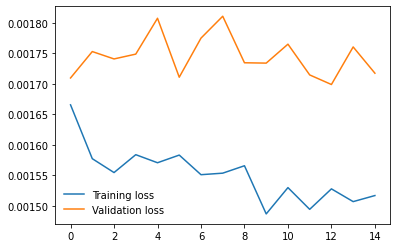

In [208]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [156]:
torchModel.to('cpu')

TorchNLP(
  (Bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [165]:
torchModel.Bert.device

device(type='cuda', index=0)

In [166]:
torchModel(X_test[:25])

Forward Called


tensor([[-1.4626, -1.5387, -1.6581,  5.5220, -1.1519, -1.9339, -0.4945],
        [-2.4869, -2.2417, -0.1596,  5.9095, -0.8429, -2.5162, -0.1103],
        [-2.2634, -1.6346,  0.2437,  5.0969, -1.4610, -0.9196,  0.4518],
        [-1.4876, -2.0991, -1.3574,  5.9189, -0.3710, -3.3775, -0.0616],
        [-1.9867, -2.1058, -0.8074,  5.6330, -0.1044, -3.1820, -0.1562],
        [-2.2982, -2.8106, -0.7049,  5.6376, -0.9757, -1.1950, -0.0750],
        [-1.3132, -0.8251, -0.8038,  4.2634, -0.0722, -2.5963,  0.0976],
        [-1.7288, -1.0971, -0.2127,  5.4893, -1.3920, -1.5332,  0.2278],
        [-2.0425, -1.3268, -1.0715,  5.6121, -0.3769, -1.5521,  0.0577],
        [-1.2958, -1.1475, -0.4645,  3.3163, -0.1179, -1.1458, -0.0809],
        [-2.9055, -2.2610, -0.9447,  6.2404, -0.8267, -2.1755,  0.2848],
        [-2.0705, -1.8187, -1.2083,  5.5571, -0.0396, -2.7881,  0.2048],
        [-1.7872, -2.5268, -1.0414,  4.4269, -0.7507, -0.7875,  0.1495],
        [-2.2243, -2.2796, -0.6230,  5.6976, -1.015

In [213]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherTest.getBatchIterator():
  
        output = torchModel.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)


1 0
100
Forward Called
2 0
100
Forward Called
3 0
100
Forward Called
4 0
100
Forward Called
5 0
100
Forward Called
6 0
100
Forward Called
7 0
100
Forward Called
8 0
100
Forward Called
9 0
100
Forward Called
10 0
100
Forward Called
11 0
0
will break


In [224]:
Y_pred = np.array(Y_pred)
targets = np.array(targets)

In [225]:
#Y_pred = torchModel.predict(X_test[200:300])
Y_pred

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 6, 4, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       2, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 2, 3, 3, 6, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3,
       4, 3, 3, 3, 2, 3, 3, 6, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       2, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [226]:
#targets = Y_test[200:300]
targets

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3,
       3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 4, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       2, 3, 3, 3, 6, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 6, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 4, 3, 3, 6, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 2, 6,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 6, 3,
       4, 3, 3, 3, 2, 3, 3, 4, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3,
       2, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [228]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

Accuracy: 0.926


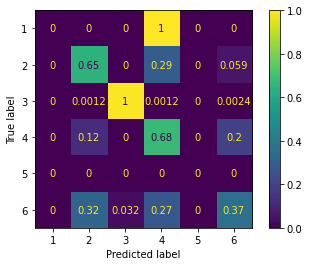

In [217]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

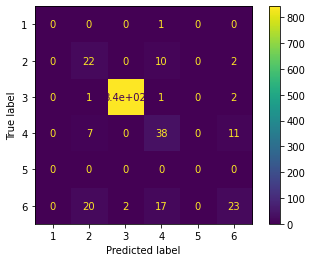

In [218]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()